# **Analisis de efectividad de campañas de Marketing en u Banco:**

## **Autores:**

- Jhon Alejandro Jaramillo Echeverri
- Juan Sebastián Salazar Luna

## **Objetivo a desarrollar:**

El objetivo de este notebook es analizar la efectividad de las campañas de marketing directo realizadas por una institución bancaria portuguesa, utilizando técnicas de preprocesamiento, modelado y evaluación de modelos de clasificación para predecir si un cliente suscribirá un depósito a plazo.

## **Conjuntos de datos**:

- ### ONI (Oceanic Niño Index):

    ##### **Descripción**:

    Los datos están relacionados con campañas de marketing directo de una institución bancaria portuguesa. Las campañas de marketing se realizaron mediante llamadas telefónicas. A menudo, se requería más de un contacto con el mismo cliente para evaluar si el producto (depósito a plazo bancario) sería suscrito ('sí') o no ('no').

    ##### **Origen de datos**:

    - Url Web: [Descripción del conjunto de datos](https://archive.ics.uci.edu/dataset/222/bank+marketing)
    - Url Datos: Es mediante el SDK que dispone UC Irvine.

    ##### **Columnas**:

    | Columna           | Descripción                                                                 |
    |-------------------|-----------------------------------------------------------------------------|
    | age               | Edad del cliente                                                          |
    | job               | Tipo de trabajo                                                           |
    | marital           | Estado civil                                                              |
    | education         | Nivel de educación                                                        |
    | default           | ¿Tiene crédito en incumplimiento? (binario: sí, no)                       |
    | balance           | Saldo promedio anual en euros                                             |
    | housing           | ¿Tiene préstamo de vivienda? (binario: sí, no)                            |
    | loan              | ¿Tiene préstamo personal? (binario: sí, no)                               |
    | contact           | Tipo de comunicación de contacto                                          |
    | day_of_week       | Último día de contacto de la semana (entero: 1-7)                         |
    | month             | Último mes de contacto del año                                            |
    | duration          | Duración del último contacto, en segundos                                 |
    | campaign          | Número de contactos realizados durante esta campaña para este cliente     |
    | pdays             | Número de días desde que el cliente fue contactado por última vez         |
    | previous          | Número de contactos realizados antes de esta campaña para este cliente    |
    | poutcome          | Resultado de la campaña de marketing anterior                             |
    | y                 | ¿El cliente ha suscrito un depósito a plazo?           |

<h1 align="center"> <b>Librerias:</b></h1>

In [62]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (

                                RandomForestRegressor
                             )

#Escalar Variables
from sklearn.preprocessing import StandardScaler

#Evaluación del modelo
from sklearn.metrics import r2_score
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error


#Creación de modelo
import statsmodels.api as sm

#from sklearn.linear_model import LinearRegression

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
import os
warnings.filterwarnings('ignore')

# Obtencion de datos
# ==============================================================================
from ucimlrepo import fetch_ucirepo 


<h1 align="center"> <b>Carga de datos:</b></h1>

In [63]:
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
# data (as pandas dataframes) 
X_raw = dict(bank_marketing.items())['data']['features']
y_raw = dict(bank_marketing.items())['data']['targets']
# Unir los dos dataframes por el índice utilizando join
df = X_raw.join(y_raw)

# Mostrar las primeras filas del dataframe combinado
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


<h1 align="center"> <b>Limpieza y transformación de datos:</b></h1>

In [64]:
print(df['job'].unique())   
df['job'] = df['job'].fillna('not data')

['management' 'technician' 'entrepreneur' 'blue-collar' nan 'retired'
 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid' 'student']


In [65]:
print(df['marital'].unique()) 

['married' 'single' 'divorced']


In [66]:
print(df['education'].unique())
df['education'] = df['education'].fillna('not data')

['tertiary' 'secondary' nan 'primary']


In [67]:
print(df['default'].unique())
df['default'] = df['default'].map({'no': 0, 'yes': 1})

['no' 'yes']


In [68]:
print(df['housing'].unique())
df['housing'] = df['housing'].map({'no': 0, 'yes': 1})

['yes' 'no']


In [69]:
print(df['loan'].unique())
df['loan'] = df['loan'].map({'no': 0, 'yes': 1})

['no' 'yes']


In [70]:
print(df['contact'].unique())
df['contact'] = df['contact'].fillna('not data')

[nan 'cellular' 'telephone']


In [71]:
print(df['month'].unique())
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
df['month'] = df['month'].map(month_mapping)
print(df['month'].unique())

['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
[ 5  6  7  8 10 11 12  1  2  3  4  9]


In [72]:
print(df['poutcome'].unique())
df['poutcome'] = df['poutcome'].fillna('not data')

[nan 'failure' 'other' 'success']


In [73]:
print(df['y'].unique())
df['y'] = df['y'].map({'no': 0, 'yes': 1})

['no' 'yes']


In [74]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,not data,5,5,261,1,-1,0,not data,0
1,44,technician,single,secondary,0,29,1,0,not data,5,5,151,1,-1,0,not data,0
2,33,entrepreneur,married,secondary,0,2,1,1,not data,5,5,76,1,-1,0,not data,0
3,47,blue-collar,married,not data,0,1506,1,0,not data,5,5,92,1,-1,0,not data,0
4,33,not data,single,not data,0,1,0,0,not data,5,5,198,1,-1,0,not data,0


In [75]:
data = pd.get_dummies(df, drop_first=True)
data.head()

,age,default,balance,housing,loan,day_of_week,month,duration,campaign,pdays,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,contact_not data,contact_telephone,poutcome_not data,poutcome_other,poutcome_success
0,58,0,2143,1,0,5,5,261,1,-1,...,True,False,False,False,True,True,False,True,False,False
1,44,0,29,1,0,5,5,151,1,-1,...,False,True,False,True,False,True,False,True,False,False
2,33,0,2,1,1,5,5,76,1,-1,...,True,False,False,True,False,True,False,True,False,False
3,47,0,1506,1,0,5,5,92,1,-1,...,True,False,False,False,False,True,False,True,False,False
4,33,0,1,0,0,5,5,198,1,-1,...,False,True,False,False,False,True,False,True,False,False



Modelo: KNN
Accuracy: 0.8909


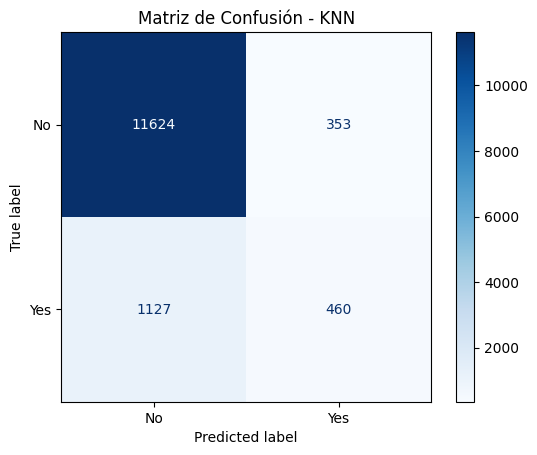


Modelo: SVM
Accuracy: 0.8984


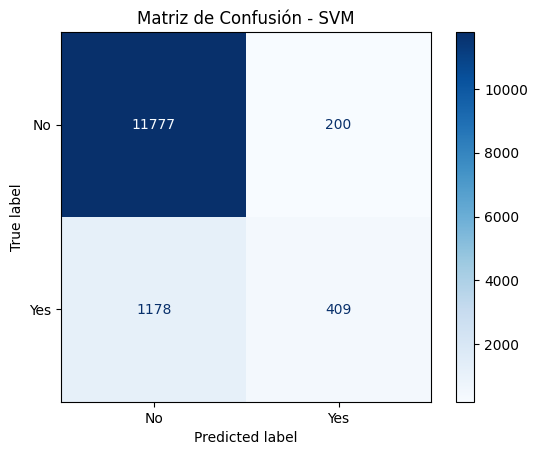


Modelo: Árbol de decisión
Accuracy: 0.8737


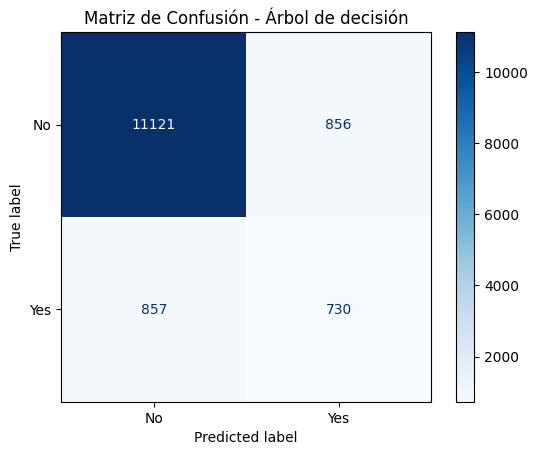


Modelo: Random Forest
Accuracy: 0.9050


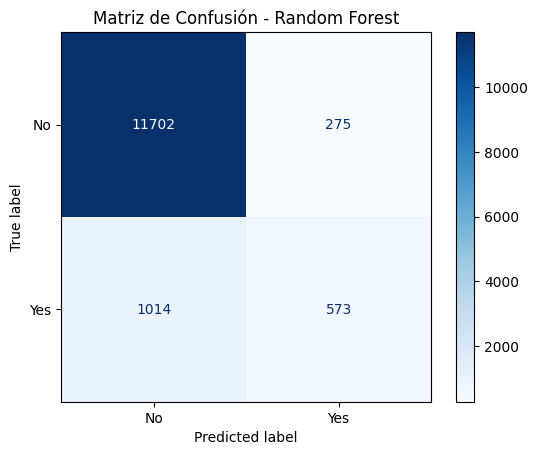


Modelo: AdaBoost
Accuracy: 0.8962


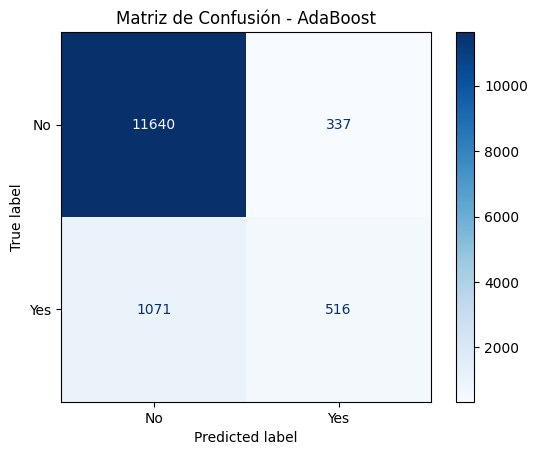


Modelo: Gradient Boosting
Accuracy: 0.9055


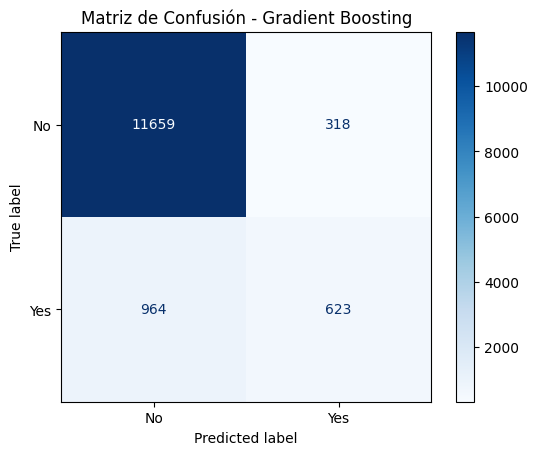


Comparación de modelos por Accuracy:
              Modelo  Accuracy
5  Gradient Boosting  0.905485
3      Random Forest  0.904969
1                SVM  0.898408
4           AdaBoost  0.896196
0                KNN  0.890888
2  Árbol de decisión  0.873710


In [76]:
# Separar características y etiquetas
X = data.drop("y", axis=1)
y = data["y"]

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# ---------------------
# 3. Modelos de clasificación
# ---------------------
modelos = {
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Árbol de decisión": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

resultados = []

# ---------------------
# 4. Entrenamiento y evaluación
# ---------------------
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    resultados.append((nombre, acc))

    print(f"\nModelo: {nombre}")
    print(f"Accuracy: {acc:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot(cmap='Blues')
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.grid(False)
    plt.show()

# ---------------------
# 5. Comparación final
# ---------------------
print("\nComparación de modelos por Accuracy:")
df_resultados = pd.DataFrame(resultados, columns=["Modelo", "Accuracy"])
print(df_resultados.sort_values(by="Accuracy", ascending=False))


<h1 align="center"> <b>Elección de los mejores hiperparametros:</b></h1>

In [54]:
#Definicion del modelo
modelGrdB = GradientBoostingClassifier(random_state=123)


# Grid de hiperparámetros evaluados
param_grid = {'n_estimators'  : [2, 3, 5],
              'max_features'  : ['sqrt', 'log2'],
              'max_depth'     : [2, 3, 5],
              'subsample'     : [0.5, 1],     # Tamaño de la muestra de datos para crear el modelo. Esto puede ayudar a reducir 
                                              # el sobreajuste y mejorar la generalización del modelo, especialmente
                                              # en conjuntos de datos grandes.
              'learning_rate' : [0.001, 0.01, 0.1]
             }

# definicion de la variable con el número de pliegues
CV = 10

# las metricas sobre las se evaluará el modelo
scoring = 'f1'

# Búsqueda por grid search con validación cruzada
grid_GrdB = GridSearchCV(
        estimator  = modelGrdB,
        param_grid = param_grid,
        scoring    = scoring,
        n_jobs     = - 1,
        cv         = CV, 
        verbose    = 0,
        return_train_score = True
       )

grid_GrdB.fit(X, y)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [2, 3, 5],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [2, 3, 5], 'subsample': [0.5, 1]},
             return_train_score=True, scoring='f1')

In [57]:
resultados = pd.DataFrame(grid_GrdB.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False)

# Obtener los resultados del grid search
results_grid_GrdB = pd.DataFrame(grid_GrdB.cv_results_)

# Seleccionar las columnas deseadas
columns_grid_GrdB = ['param_learning_rate'] + \
                    ['param_max_depth'] + \
                    ['param_max_features'] + \
                    ['param_n_estimators'] + \
                    ['param_subsample'] + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_GrdB_filtered = results_grid_GrdB[columns_grid_GrdB]

# Crear la columna scoreWithStd: f1 / std
results_grid_GrdB_filtered['scoreWithStd'] = results_grid_GrdB_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_GrdB_filtered['scoreWithStd'].idxmax()

# Top 3 de los mejores scores
results_grid_GrdB_filtered.sort_values(by='scoreWithStd', ascending=False).head(10)[
    ['param_learning_rate','param_max_depth','param_max_features','param_n_estimators'
     , 'mean_test_score', 'std_test_score', 'scoreWithStd']].head(3)

C:\Users\juane\AppData\Local\Temp\ipykernel_21104\1077234340.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_grid_GrdB_filtered['scoreWithStd'] = results_grid_GrdB_filtered.apply(


,param_learning_rate,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
100,0.1,5,sqrt,5,0.014351,0.043053,0.333333
106,0.1,5,log2,5,0.014351,0.043053,0.333333
88,0.1,3,sqrt,5,0.013000,0.039000,0.333333


In [59]:
registro_max_scoreWithStd = results_grid_GrdB_filtered.loc[indice_max_scoreWithStd]

# Usar los mejores parámetros para crear el modelo
modelGrdB.set_params(learning_rate = results_grid_GrdB_filtered.loc[indice_max_scoreWithStd]['param_learning_rate']                         
                         , max_depth = results_grid_GrdB_filtered.loc[indice_max_scoreWithStd]['param_max_depth']
                         , max_features = results_grid_GrdB_filtered.loc[indice_max_scoreWithStd]['param_max_features']
                         , n_estimators = results_grid_GrdB_filtered.loc[indice_max_scoreWithStd]['param_n_estimators']                    
                    )

modelGrdB.fit(X, y)

#Importancia por pureza de nodos

importancia_predictores = pd.DataFrame(
                            {'predictor': X.columns,
                             'importancia': modelGrdB.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
7,duration,4.166488e-01
31,poutcome_success,3.394120e-01
27,contact_not data,5.431598e-02
9,pdays,4.681640e-02
0,age,4.094902e-02
29,poutcome_not data,2.306042e-02
3,housing,1.847920e-02
6,month,1.705268e-02
19,job_student,6.498380e-03
2,balance,5.272543e-03


Text(0.5, 1.0, 'Importancia de los predictores')

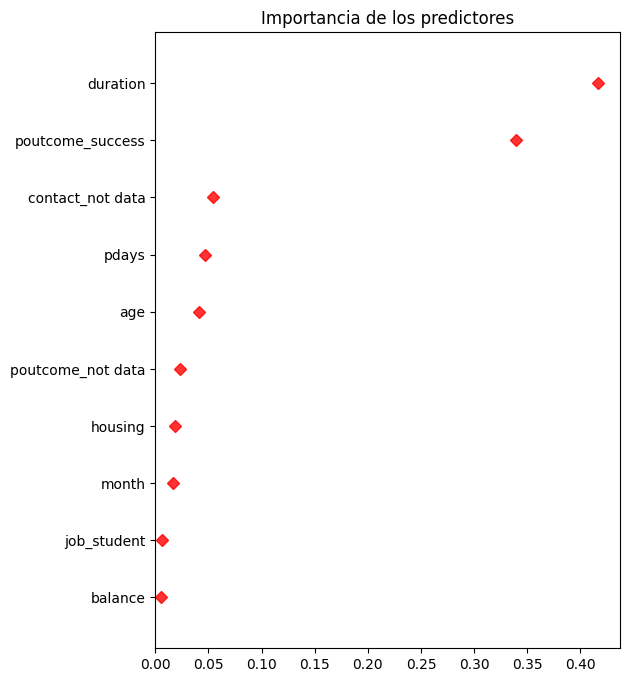

In [60]:
# Gráfico
fig, ax = plt.subplots(figsize=(6, 8))
df_importancia = importancia_predictores.nlargest(10, 'importancia').sort_values('importancia', ascending=True)

ax.barh(
    df_importancia['predictor'],
    df_importancia['importancia'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importancia'],
    df_importancia['predictor'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores')

<h1 align="center"> <b>Conclusiones:</b></h1>

1. **Importancia de los predictores**:  
    - La variable más importante para predecir si un cliente suscribirá un depósito a plazo es la duración de la última llamada (`duration`), seguida por el resultado de campañas anteriores (`poutcome_success`) y el tipo de contacto (`contact_not data`).

2. **Mejor modelo de clasificación**:  
    - El modelo de Gradient Boosting obtuvo el mejor desempeño con una precisión (`Accuracy`) de **0.9055**, superando a otros modelos como Random Forest y SVM.
